In [14]:
import pandas as pd
from IPython.display import Image, display
import base64

api_key = '6669d7a6eb70f4.27564131'

# Top S&P 500 
tickers = ['AAPL.US','MSFT.US','MSFT.US','NVDA.US','AMZN.US','META.US','GOOGL.US','GOOG.US','LLY.US','JPM.US','BRK-B.US,','V.US','PG.US','UNH.US','AVGO.US','JNJ.US']

# Constants for the number of days before earnings and after dividend
days_after_dividend = 0  # Number of days after the dividend to buy
days_before_earnings = 0  # Number of days before earnings to sell

# Define the period of analysis
start_date = '2019-09-09'
end_date = '2024-09-09'

# Initial nominal investment in each stock
initial_investment = 1000

import download_info as di

downloaded_data = di.download_data(api_key, tickers, start_date, end_date)



Fetching data for AAPL.US...
Loading from cache: cache\AAPL.US\eod_AAPL.US\from_2019-09-09_to_2024-09-09_api_token_6669d7a6eb70f4_27564131_fmt_json.json
Loading from cache: cache\AAPL.US\calendar_earnings\api_token_6669d7a6eb70f4_27564131_from_2019-09-09_to_2024-09-09_symbols_AAPL_US_fmt_json.json
Loading from cache: cache\AAPL.US\div_AAPL.US\from_2019-09-09_to_2024-09-09_api_token_6669d7a6eb70f4_27564131_fmt_json.json
Loading from cache: cache\AAPL.US\historical-market-cap_AAPL.US\from_2019-09-09_to_2024-09-09_api_token_6669d7a6eb70f4_27564131_fmt_json.json

Fetching data for MSFT.US...
Loading from cache: cache\MSFT.US\eod_MSFT.US\from_2019-09-09_to_2024-09-09_api_token_6669d7a6eb70f4_27564131_fmt_json.json
Loading from cache: cache\MSFT.US\calendar_earnings\api_token_6669d7a6eb70f4_27564131_from_2019-09-09_to_2024-09-09_symbols_MSFT_US_fmt_json.json
Loading from cache: cache\MSFT.US\div_MSFT.US\from_2019-09-09_to_2024-09-09_api_token_6669d7a6eb70f4_27564131_fmt_json.json
Loading fr

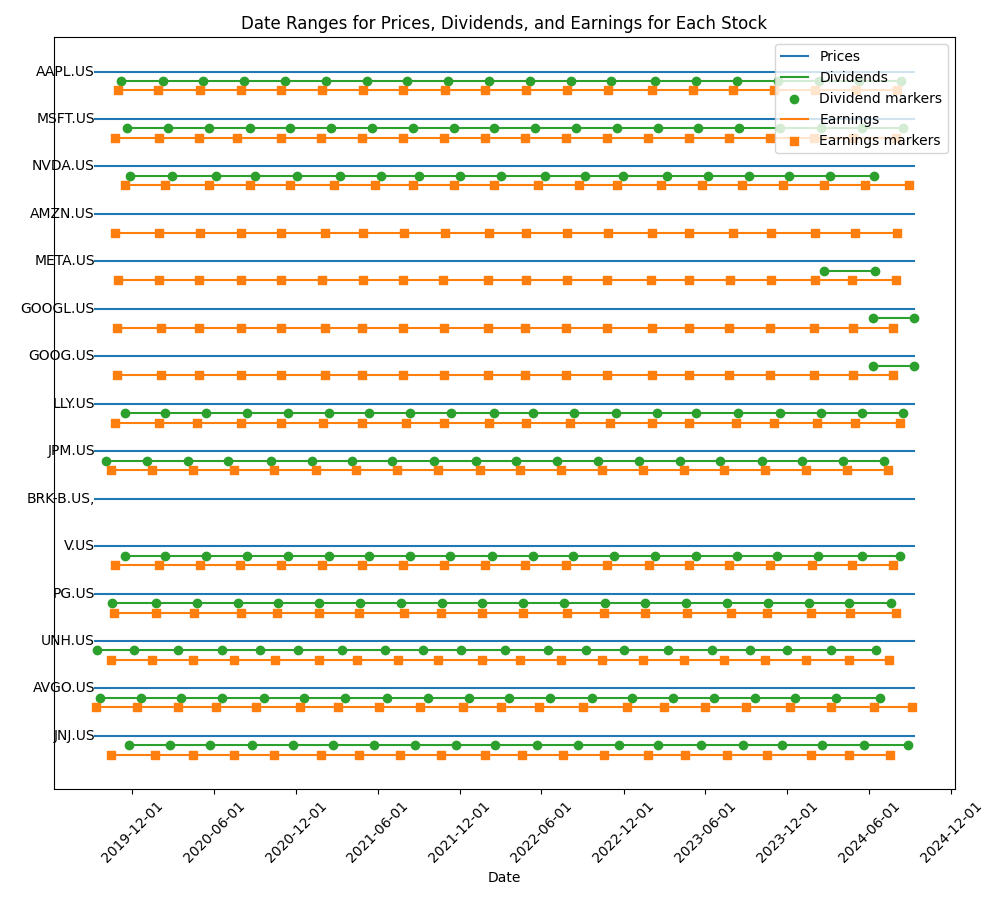

In [15]:
import chart_available_dates as cad
base64_image = cad.plot_stock_date_ranges(downloaded_data)
display(Image(data=base64.b64decode(base64_image), format='png'))

In [16]:
import food_stock_strategy_simulation as fss
market_caps = fss.process_market_caps(downloaded_data)
top_stocks_by_date = fss.create_top_stocks_by_date(market_caps, start_date, end_date, 5)

No data for MSFT.US on or before 2019-09-09 00:00:00
No data for NVDA.US on or before 2019-09-09 00:00:00
No data for AMZN.US on or before 2019-09-09 00:00:00
No data for META.US on or before 2019-09-09 00:00:00
No data for GOOGL.US on or before 2019-09-09 00:00:00
No data for GOOG.US on or before 2019-09-09 00:00:00
No data for LLY.US on or before 2019-09-09 00:00:00
No data for JPM.US on or before 2019-09-09 00:00:00
No data for BRK-B.US, on or before 2019-09-09 00:00:00
No data for V.US on or before 2019-09-09 00:00:00
No data for PG.US on or before 2019-09-09 00:00:00
No data for UNH.US on or before 2019-09-09 00:00:00
No data for AVGO.US on or before 2019-09-09 00:00:00
No data for JNJ.US on or before 2019-09-09 00:00:00
No data for MSFT.US on or before 2019-09-10 00:00:00
No data for NVDA.US on or before 2019-09-10 00:00:00
No data for AMZN.US on or before 2019-09-10 00:00:00
No data for META.US on or before 2019-09-10 00:00:00
No data for GOOGL.US on or before 2019-09-10 00:00:0

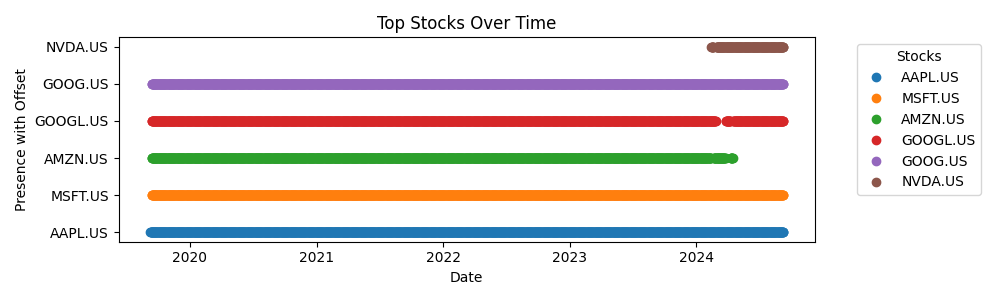

In [17]:
import chart_top_stocks as cts
plot_top_stocks_base64 = cts.chart_top_stocks(top_stocks_by_date)
display(Image(data=base64.b64decode(plot_top_stocks_base64), format='png'))

In [18]:
import food_stock_strategy_simulation as fss
investment_results = fss.process(downloaded_data, top_stocks_by_date, days_after_dividend, days_before_earnings, initial_investment)

Bought: AAPL.US, Pool: 0, Date: 2019-11-07, Investment: $1000.00
No free capital for MSFT.US on 2019-11-20
Bought: MSFT.US, Pool: 1, Date: 2019-11-20, Investment: $1000.00
Sold: MSFT.US, Pool: 0, Date: 2020-01-28, Gain: $224.57, Total Return: $1224.57
Sold: MSFT.US, Pool: 1, Date: 2020-01-29, Gain: $123.11, Total Return: $1123.11
Bought: AAPL.US, Pool: 0, Date: 2020-02-07, Investment: $1224.57
No free capital for MSFT.US on 2020-02-19
Bought: MSFT.US, Pool: 1, Date: 2020-02-19, Investment: $1123.11
Sold: MSFT.US, Pool: 1, Date: 2020-04-29, Gain: $-59.07, Total Return: $1064.04
Sold: AAPL.US, Pool: 0, Date: 2020-04-30, Gain: $-100.37, Total Return: $1124.20
Bought: AAPL.US, Pool: 0, Date: 2020-05-08, Investment: $1124.20
No free capital for MSFT.US on 2020-05-20
Bought: MSFT.US, Pool: 1, Date: 2020-05-20, Investment: $1064.04
Sold: MSFT.US, Pool: 1, Date: 2020-07-22, Gain: $149.53, Total Return: $1213.57
Sold: AAPL.US, Pool: 0, Date: 2020-07-30, Gain: $270.53, Total Return: $1394.73
Bou

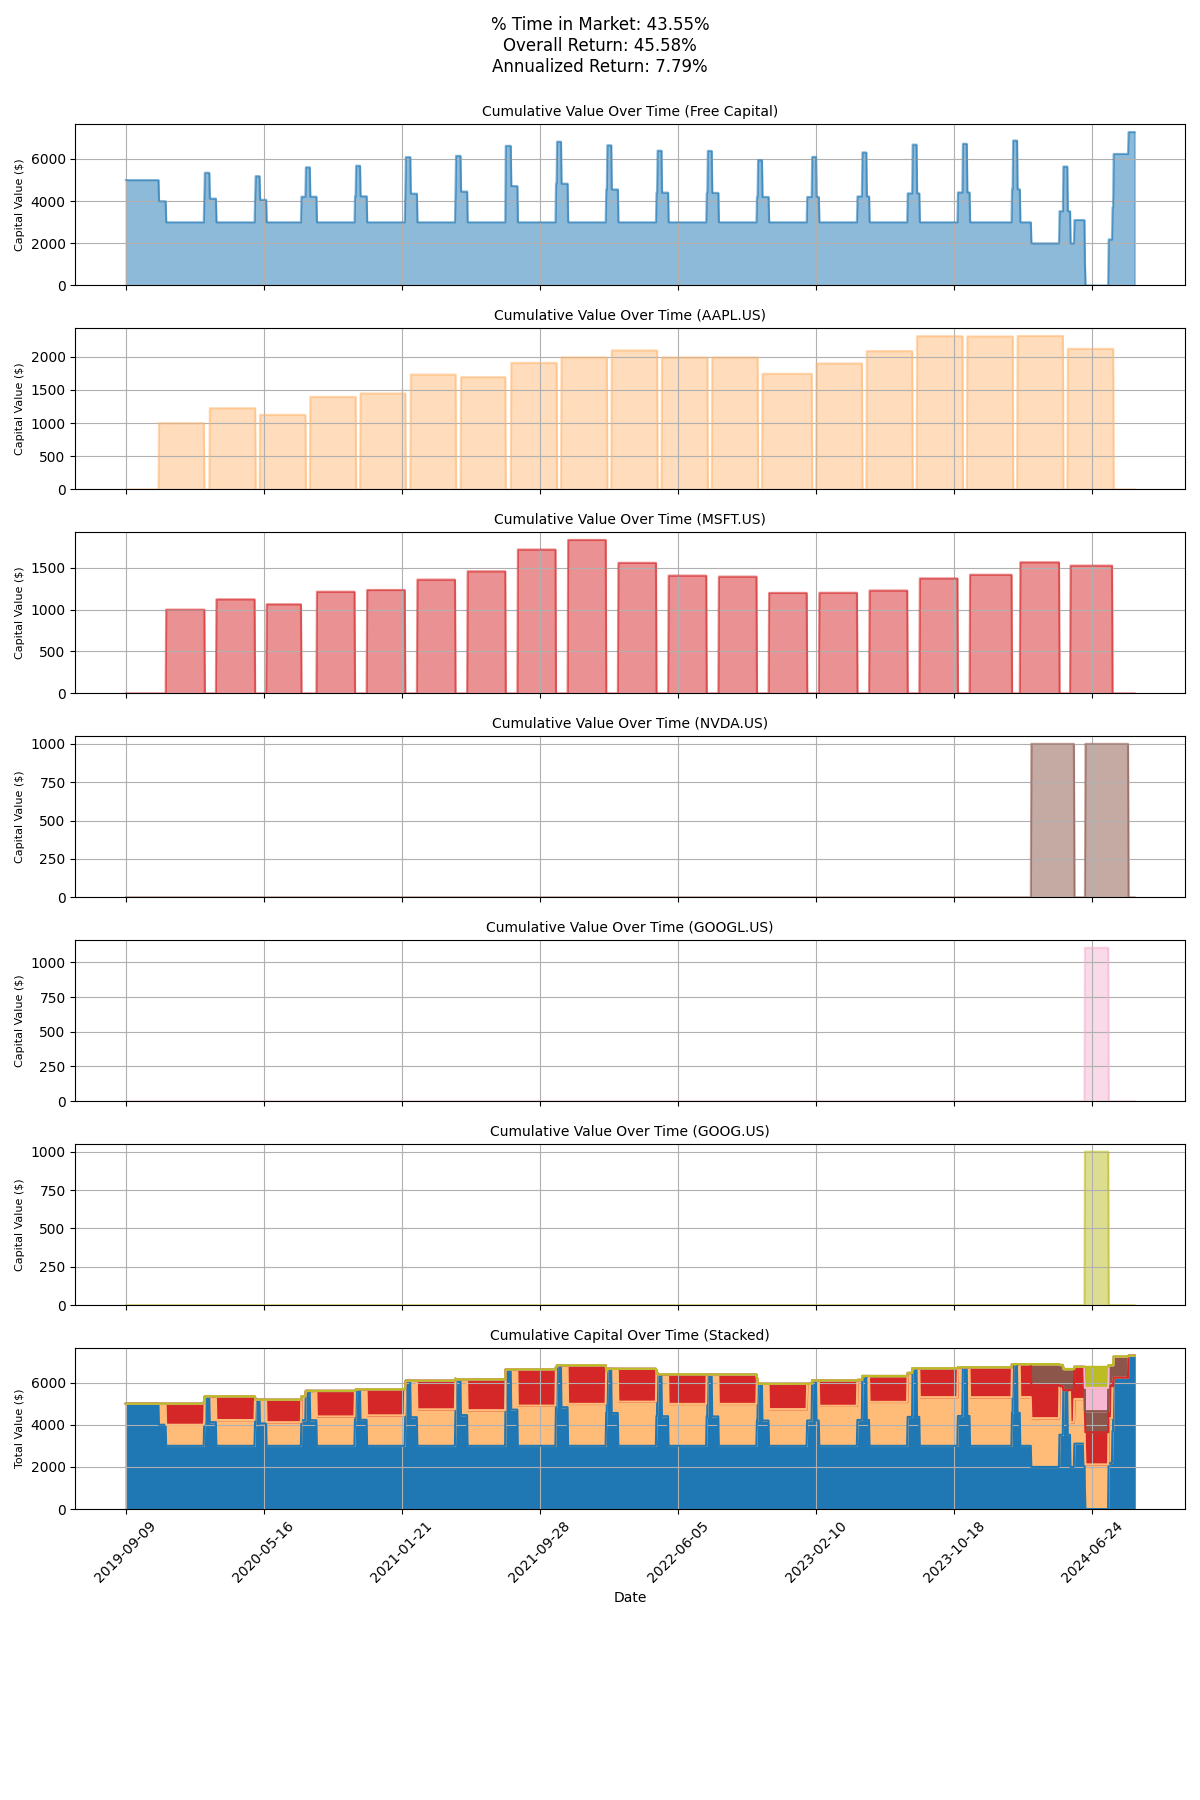

In [19]:
import chart_combined as cc
base64_image = cc.chart_combined(investment_results, start_date, end_date)
display(Image(data=base64.b64decode(base64_image), format='png'))